In [1]:
from numpy import *
from numpy.random import randn 
from numpy.linalg import cholesky 
from scipy.linalg import cho_solve, cho_factor 

# colors:
dark  = array([51.,51.,51.]) / 255.;
red   = array([141.,45.,57.]) / 255.;
gold  = array([174.,159.,109.]) / 255.;
gray  = array([175.,179.,183.]) / 255.;
lred  = array([1,1,1]) - 0.5 * (array([1,1,1]) - red);
lgold = array([1,1,1]) - 0.5 * (array([1,1,1]) - gold);

## Gaussian inference on linear functions

In [5]:
#                            ==== PARAMETRIC GAUSSIAN REGRESSION IN PYTHON ====
# prior on w
F     = 2                                                  # number of features
phi   = lambda a : power(a,range(F))                           # phi(a) = [1,a]
# ^^^^ change this line to get nonlinear models. See below for examples of other features
mu    = zeros((F,1))
Sigma = eye(F)                                               # p(w)=N(mu,Sigma)

# implied prior on f_x
n     = 100
x     = reshape(linspace(-8,8,n),(n,1))     # reshape is needed for phi to work
m     = dot(phi(x),mu)                        # $m = \phi(x)' * \mu$
kxx   = dot(dot(phi(x),Sigma),phi(x).transpose())            # p(f_x)=N(m,k_xx)
s     = dot(cholesky(kxx + 1e-6 * eye(n)),randn(n,5)) + m       # prior samples
stdpi = reshape(sqrt(diag(kxx)),[n,1])          # marginal stddev, for plotting

# loading data from disk
import scipy.io; data = scipy.io.loadmat('lindata.mat')
# import scipy.io; data = scipy.io.loadmat('nlindata.mat') # use this line to get the nonlinear data. 
X = data['X']; Y = data['Y']; sigma = data['sigma']; N  = len(X)

# prior on Y = f_X + eps
M     = dot(phi(X),mu)
kXX   = dot(dot(phi(X),Sigma),phi(X).transpose())          # p(f_X) = N(M,k_XX)

# inference
G     = cho_factor(kXX + sigma**2 * eye(N))       # Most expensive step, O(N^3)
kxX   = dot(dot(phi(x),Sigma),phi(X).transpose())         # Cov(f_x,f_X) = k_xX
A     = cho_solve(G,kxX.transpose()).transpose()       # pre-compute for re-use

# # posterior p(f_x|Y)
mpost = m + dot(A,(Y-M))                                                 # mean
vpost = kxx - dot(A,kxX.transpose())                               # covariance
spost = dot(cholesky(vpost + 1e-8 * eye(n)),randn(n,5)) + mpost       # samples
stdpo = reshape(sqrt(diag(vpost)),[n,1])        # marginal stddev, for plotting

## plotting

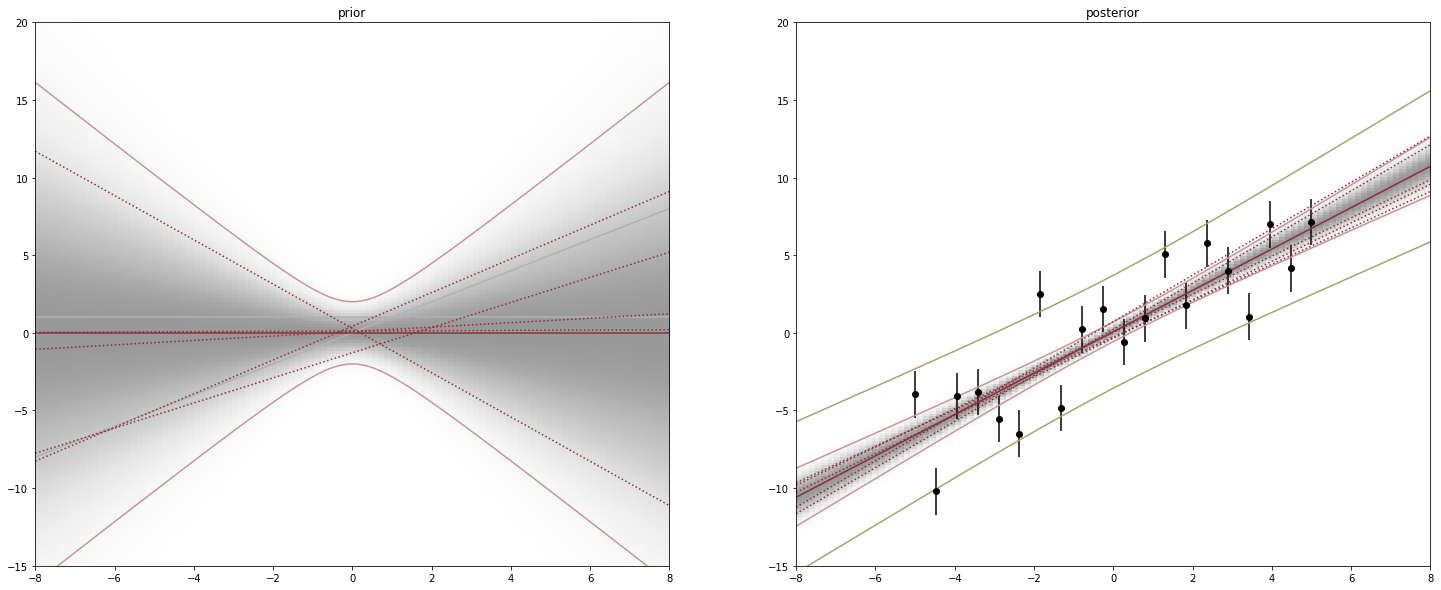

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (25, 10)
fig,ax = plt.subplots(1,2)

# shading:
GaussPDFscaled = lambda y, m, s : exp(-0.5*(y-m.transpose())**2 / (s**2).transpose());
yy = linspace(-15,20,200).reshape([200,1])
P  = GaussPDFscaled(yy,m,stdpi)

ax[0].imshow(P,extent=[-8,8,-15,20],aspect='auto',origin='lower',cmap='Greys',alpha=0.4)
ax[0].plot(x,phi(x),'-',color=gray)
ax[0].plot(x,s,':',color=red)                   # prior
ax[0].plot(x,m,'-',color=red)
ax[0].plot(x,m + 2 * stdpi,'-',color=lred)
ax[0].plot(x,m - 2 * stdpi,'-',color=lred)
ax[0].set(xlim=[-8,8],ylim=[-15,20],title="prior")   

Ppost  = GaussPDFscaled(yy,mpost,stdpo) # shading by local marginal pdf
ax[1].imshow(Ppost,extent=[-8,8,-15,20],aspect='auto',origin='lower',cmap='Greys',alpha=0.4)
ax[1].errorbar(X,Y,yerr=sigma*(0*Y+1),fmt='ok') # data
ax[1].plot(x,mpost,'-',color=red)               # posterior mean
ax[1].plot(x,mpost + 2* stdpo,'-',color=lred)   # upper error bars on f
ax[1].plot(x,mpost - 2* stdpo,'-',color=lred)   # lower error bars on f

ax[1].plot(x,mpost + 2 * stdpo + 2*sigma,'-',color=gold)   # predictive error bars (on y)
ax[1].plot(x,mpost - 2 * stdpo - 2*sigma,'-',color=gold)

ax[1].plot(x,spost,':',color=red)               # samples
ax[1].set(xlim=[-8,8],ylim=[-15,20],title="posterior")

plt.show()

In [7]:
# some other options for the feature functions to try. Try around! Try scaling and changing the prior and/or the features (note that there are a few degrees of freedom shared between them)
phi   = lambda a : 2*(a>linspace(-8,8,F).transpose())             # steps that switch on
phi   = lambda a : 2*((a>linspace(-8,8,F).transpose())-0.5)       # steps that change sign
phi   = lambda a : 1*(abs(a-linspace(-8,8,F).transpose())-linspace(-8,8,F))       # linear
phi   = lambda a : 3*hstack((sin(a * range(4)),cos(a * range(4)))); F=8   # Fourier features
phi   = lambda a : 5*exp(-(a-linspace(-8,8,F).transpose())**2/2./0.5**2)  # Gaussian / RBF / SE features
phi   = lambda a : 5*exp(-abs(a-linspace(-8,8,F).transpose())/1**2)       # "Eiffel towers"